## Imports and Setup
Checks for GPU and sets up libraries.

In [9]:
import os
import json
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt

# --- Configuration ---
# Reduced Batch Size to prevent CUDA OOM with your large model
BATCH_SIZE = 4        
LEARNING_RATE = 1e-4
EPOCHS = 50
PHYSICS_WEIGHT = 0.1
OUTPUT_DIR = "/kaggle/working" 

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Device: {device}")

# Locate Dataset
search_path = "/kaggle/input/**/*.pt"
pt_files = glob.glob(search_path, recursive=True)
if not pt_files:
    raise FileNotFoundError("❌ Dataset not found! Add 'fluid-super-resolution' to notebook.")
DATA_FILE = pt_files[0]
DATA_DIR = os.path.dirname(DATA_FILE)
STATS_FILE = os.path.join(DATA_DIR, "normalization_stats.json")
print(f"📂 Data: {DATA_FILE}")

🚀 Device: cuda
📂 Data: /kaggle/input/fluid-sim-dataset/processed_dataset.pt


## Configuration and File Discovery
Finds your dataset automatically.

In [10]:
# --- Configuration ---
BATCH_SIZE = 16        # Reduced to 16 for safety
LEARNING_RATE = 1e-4
EPOCHS = 50
PHYSICS_WEIGHT = 0.1
OUTPUT_DIR = "/kaggle/working" 

# --- Find Dataset Files ---
# Search for the .pt file in the input directory
search_path = "/kaggle/input/**/*.pt"
pt_files = glob.glob(search_path, recursive=True)

if not pt_files:
    raise FileNotFoundError("❌ Could not find 'processed_dataset.pt'. Did you add the dataset?")

DATA_FILE = pt_files[0]
DATA_DIR = os.path.dirname(DATA_FILE)
STATS_FILE = os.path.join(DATA_DIR, "normalization_stats.json")

print(f"📂 Dataset found at: {DATA_FILE}")
print(f"📂 Stats expected at: {STATS_FILE}")

📂 Dataset found at: /kaggle/input/fluid-sim-dataset/processed_dataset.pt
📂 Stats expected at: /kaggle/input/fluid-sim-dataset/normalization_stats.json


## Model Architecture (ResUNet)

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class ResUNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=2, features=[64, 128, 256, 512]):
        super(ResUNet, self).__init__()
        self.encoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder
        self.input_conv = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=3, padding=1),
            nn.BatchNorm2d(features[0]),
            nn.ReLU(inplace=True)
        )
        input_feat = features[0]
        for feature in features:
            self.encoder.append(ResidualBlock(input_feat, feature))
            input_feat = feature

        # Bottleneck
        self.bottleneck = ResidualBlock(features[-1], features[-1] * 2)

        # Decoder
        self.upconvs = nn.ModuleList()
        self.decoder = nn.ModuleList()
        features = features[::-1]
        for feature in features:
            self.upconvs.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.decoder.append(ResidualBlock(feature * 2, feature))

        # Output
        self.final_conv = nn.Conv2d(features[-1], out_channels, kernel_size=1)
        
    def forward(self, x):
        skip_connections = []
        out = self.input_conv(x)
        
        for layer in self.encoder:
            out = layer(out)
            skip_connections.append(out)
            out = self.pool(out)
            
        out = self.bottleneck(out)
        skip_connections = skip_connections[::-1] 
        
        for idx in range(len(self.decoder)):
            out = self.upconvs[idx](out)
            skip = skip_connections[idx]
            # Safe interpolation in case sizes don't perfectly match
            if out.shape != skip.shape:
                out = F.interpolate(out, size=skip.shape[2:], mode='bilinear', align_corners=False)
            concat_skip = torch.cat((skip, out), dim=1)
            out = self.decoder[idx](concat_skip)
            
        out = self.final_conv(out)
        
        # Global Residual: Add to middle frame
        base_frame = x[:, 2:4, :, :] 
        return base_frame + out

## Dataset Class
Memory-mapped loading logic.

In [12]:
class FluidLoader(Dataset):
    def __init__(self, pt_file, stats_file):
        print(f"⏳ Loading data map...")
        try:
            # mmap=True is crucial for Kaggle RAM limits
            data = torch.load(pt_file, map_location='cpu', mmap=True)
        except:
            print("⚠️ mmap failed. Loading to RAM (Risk of Restart).")
            data = torch.load(pt_file, map_location='cpu')
            
        self.inputs = data['inputs']
        self.targets = data['targets']
        
        # Load K
        if 'K' in data:
            self.K = float(data['K'])
        elif os.path.exists(stats_file):
            with open(stats_file, 'r') as f:
                self.K = float(json.load(f)['scaling_factor'])
        else:
            self.K = 1.0
            
        print(f"✅ Loaded {len(self.inputs)} samples. Input shape: {self.inputs.shape}. K={self.K}")

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        lr = self.inputs[idx] # Might be 32x32 or 256x256
        hr = self.targets[idx] # Should be 256x256
        
        # Safety check: If data is stored as 32x32, upscale it now.
        # Your model expects 256x256 input.
        if lr.shape[-1] != 256:
            lr = F.interpolate(
                lr.unsqueeze(0), 
                size=(256, 256), 
                mode='bilinear', 
                align_corners=False
            ).squeeze(0)
            
        return lr, hr

## Physics Loss
Divergence calculation

In [13]:
class PhysicsLoss(nn.Module):
    def __init__(self):
        super(PhysicsLoss, self).__init__()

    def forward(self, output, scaling_factor):
        # Un-scale to physical units
        u = output * scaling_factor
        u_x = u[:, 0, :, :]
        u_y = u[:, 1, :, :]

        # Divergence (Forward Difference)
        du_dx = u_x[:, :, 1:] - u_x[:, :, :-1]
        dv_dy = u_y[:, 1:, :] - u_y[:, :-1, :]
        
        # Crop to match shapes
        du_dx_cut = du_dx[:, :-1, :]
        dv_dy_cut = dv_dy[:, :, :-1]

        # Conservation of Mass: div(u) should be 0
        divergence = du_dx_cut + dv_dy_cut
        return torch.mean(divergence**2)

## Training Loop
With Mixed Precision (autocast).

In [14]:
def train(use_physics=False):
    # 1. Data
    dataset = FluidLoader(DATA_FILE, STATS_FILE)
    train_sz = int(0.8 * len(dataset))
    val_sz = len(dataset) - train_sz
    train_ds, val_ds = random_split(dataset, [train_sz, val_sz], generator=torch.Generator().manual_seed(42))
    
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # 2. Setup
    model = ResUNet(in_channels=6, out_channels=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scaler = GradScaler() # For AMP
    
    mse = nn.MSELoss()
    phys = PhysicsLoss() if use_physics else None
    K = dataset.K
    
    mode_name = "PINN" if use_physics else "Baseline"
    print(f"\n🚀 Starting {mode_name} Training...")
    
    hist = {'train': [], 'val': []}

    # 3. Loop
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            
            # Mixed Precision Forward
            with autocast():
                pred = model(x)
                loss = mse(pred, y)
                if use_physics:
                    loss += PHYSICS_WEIGHT * phys(pred, K)
            
            # Backward
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                # Validation doesn't need scaling, just checking MSE
                pred = model(x)
                val_loss += mse(pred, y).item()
        
        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        hist['train'].append(avg_train)
        hist['val'].append(avg_val)
        
        print(f"Epoch {epoch+1}/{EPOCHS} | Train: {avg_train:.6f} | Val: {avg_val:.6f}")
        
        # Save
        if (epoch+1) % 10 == 0:
            torch.save(model.state_dict(), f"{OUTPUT_DIR}/{mode_name}_epoch_{epoch+1}.pth")

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(hist['train'], label='Train')
    plt.plot(hist['val'], label='Val')
    plt.title(f'{mode_name} Loss Curve')
    plt.legend()
    plt.savefig(f"{OUTPUT_DIR}/{mode_name}_history.png")
    plt.show()
    
    return model, dataset

## Execute
Run this cell to start.

⏳ Loading data map...
✅ Loaded 5920 samples. Input shape: torch.Size([5920, 6, 256, 256]). K=8.0

🚀 Starting Baseline Training...


/tmp/ipykernel_47/470595948.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() # For AMP
/tmp/ipykernel_47/470595948.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/50 | Train: 0.003027 | Val: 0.000436
Epoch 2/50 | Train: 0.000438 | Val: 0.000282
Epoch 3/50 | Train: 0.000291 | Val: 0.000209
Epoch 4/50 | Train: 0.000215 | Val: 0.000153
Epoch 5/50 | Train: 0.000172 | Val: 0.000145
Epoch 6/50 | Train: 0.000141 | Val: 0.000096
Epoch 7/50 | Train: 0.000115 | Val: 0.000102
Epoch 8/50 | Train: 0.000101 | Val: 0.000086
Epoch 9/50 | Train: 0.000095 | Val: 0.000083
Epoch 10/50 | Train: 0.000083 | Val: 0.000061
Epoch 11/50 | Train: 0.000073 | Val: 0.000055
Epoch 12/50 | Train: 0.000067 | Val: 0.000066
Epoch 13/50 | Train: 0.000063 | Val: 0.000060
Epoch 14/50 | Train: 0.000058 | Val: 0.000049
Epoch 15/50 | Train: 0.000055 | Val: 0.000064
Epoch 16/50 | Train: 0.000052 | Val: 0.000040
Epoch 17/50 | Train: 0.000045 | Val: 0.000042
Epoch 18/50 | Train: 0.000044 | Val: 0.000037
Epoch 19/50 | Train: 0.000041 | Val: 0.000039
Epoch 20/50 | Train: 0.000037 | Val: 0.000032
Epoch 21/50 | Train: 0.000037 | Val: 0.000032
Epoch 22/50 | Train: 0.000035 | Val: 0.0000

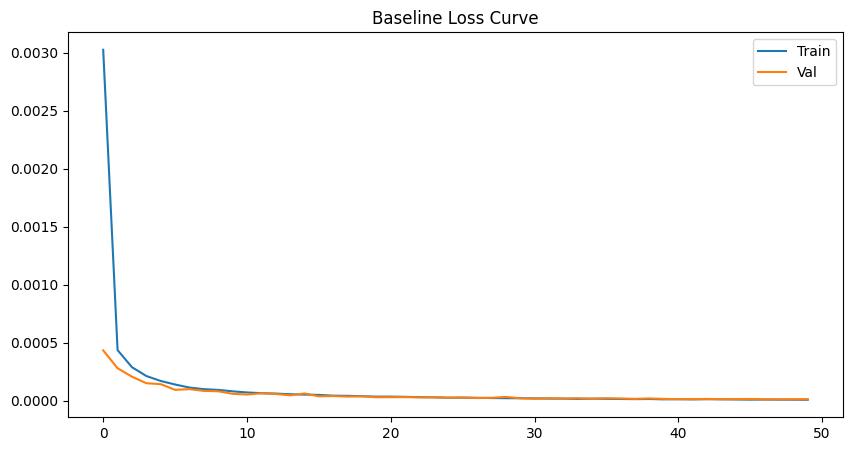

In [15]:
# Run Baseline
model, ds = train(use_physics=False)

# Run PINN
# model_pinn, ds = train(use_physics=True)

## Visualize Prediction

In [ ]:
# Visualization Function
def visualize_prediction(model, dataset, idx=0):
    model.eval()
    lr_sample, hr_target = dataset[idx]
    
    # Prepare input
    lr_input = lr_sample.unsqueeze(0).to(device)
    
    with torch.no_grad():
        pred = model(lr_input).cpu().squeeze(0)
        
    # Calculate Magnitudes
    def get_mag(tensor):
        return np.sqrt(tensor[0]**2 + tensor[1]**2)
    
    lr_mag = get_mag(lr_sample[2:4].numpy()) # Middle frame of input
    hr_mag = get_mag(hr_target.numpy())
    pred_mag = get_mag(pred.numpy())
    
    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(lr_mag, cmap='inferno', origin='lower')
    ax[0].set_title("Low Res Input (32x32)")
    
    ax[1].imshow(pred_mag, cmap='inferno', origin='lower')
    ax[1].set_title("SR Prediction (256x256)")
    
    ax[2].imshow(hr_mag, cmap='inferno', origin='lower')
    ax[2].set_title("Ground Truth (256x256)")
    plt.show()

# Show a random sample
import random
idx = random.randint(0, len(dataset)-1)
visualize_prediction(model, dataset, idx)